In [1]:
import dowhy
import dowhy.datasets
import pandas as pd
from os.path import join
import numpy as np
from lightgbm import LGBMRegressor
from econml.orf import DMLOrthoForest, DROrthoForest
import sklearn

1 variables are assumed unobserved because they are not in the dataset. Configure the logging level to `logging.WARNING` or higher for additional details.


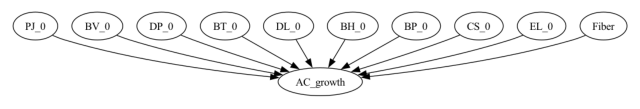

In [3]:
SPECIES = ['PJ', 'BV', 'AC', 'DP', 'BT', 'DL', 'BH', 'BP',
       'CS', 'EL']
FOLDER = join('Data', 'Species')
def load_growth_data(filename):
    """Load growth data from a CSV file."""
    data = pd.read_csv(join(FOLDER, filename))
    
    data_growth = (data[data['Time'] == 24][SPECIES].values - data[data['Time'] == 0][SPECIES].values )
    
    growth_df = pd.DataFrame(data_growth, columns=SPECIES)
    growth_df['Treatments'] = data[data['Time'] == 24]['Treatments'].values
    growth_df = growth_df.reset_index(drop=True)
    growth_df['Comm'] = data[data['Time'] == 24]['Comm'].values
    for comm_bin in growth_df.index:
        commposition = growth_df.loc[comm_bin, 'Comm']
        communities = commposition.split('-')
        for specie in communities:
            specie_bin = specie + '_bin'
            if specie not in SPECIES:
                growth_df.loc[comm_bin, specie_bin] = 0
            else:
                growth_df.loc[comm_bin, specie_bin] = 1
    return growth_df

dynamics_AC = pd.read_csv(join(FOLDER, 'AC_growth_profile.csv'))

organism_i = 'PJ' # effector
organism_j = 'AC' # to predict

treatment = organism_i + '_0'
outcome = organism_j + '_growth'


growth_AC = dynamics_AC[dynamics_AC['Time'] == 24][organism_j] - dynamics_AC[dynamics_AC['Time'] == 0][organism_j].rename(outcome)
treatment_val = dynamics_AC[dynamics_AC['Time'] == 0][organism_i].rename(treatment)
data = pd.concat([treatment_val, growth_AC], axis=1)

confounders_df = dynamics_AC[dynamics_AC['Time'] == 0][[*SPECIES]]
confounders_df.drop(columns=[organism_j, organism_i], inplace=True)
confounders_df.rename(columns={s: s + '_0' for s in SPECIES}, inplace=True)
confounders_df['Fiber'] = dynamics_AC[dynamics_AC['Time'] == 0]['Treatments']

confounders = confounders_df.columns.tolist()

data = pd.concat([data, confounders_df], axis=1)


# Build causal model
causal_graph = f"""
digraph {{
    {treatment} -> {outcome};
    {"; ".join([c + " -> " + outcome for c in confounders])};
}}
"""

model = dowhy.CausalModel(
    data=data,
    treatment=treatment,
    outcome=outcome,
    common_causes=confounders,
    graph=causal_graph
)
model.view_model()


In [ ]:
from dowhy import CausalModel
import pandas as pd

# Replace with your data
data = df.copy()

organism_i = 'org_A'
organism_j = 'org_B'

treatment = f"X0_{organism_i}"
outcome = f"log_growth_{organism_j}"

# Compute growth
eps = 1e-6
data[outcome] = np.log((data[f"X24_{organism_j}"] + eps) / (data[f"X0_{organism_j}"] + eps))

# Define confounders: all initial abundances except i and j
confounders = [col for col in data.columns if col.startswith("X0_") and col not in [treatment, f"X0_{organism_j}"]]
confounders += ["Fiber"]

# Build causal model
causal_graph = f"""
digraph {{
    {treatment} -> {outcome};
    {"; ".join([c + " -> " + outcome for c in confounders])};
}}
"""

model = CausalModel(
    data=data,
    treatment=treatment,
    outcome=outcome,
    common_causes=confounders,
    graph=causal_graph
)
model.view_model()

,PJ_0,BV_0,AC_0,DP_0,BT_0,DL_0,BH_0,BP_0,CS_0,EL_0,AC_24,Treatments
0,0.000497,0.011394,0.007156,0.020968,0.002733,0.033991,0.002984,0.000497,0.000494,0.003338,0.191100,Inulin
1,0.000227,0.004001,0.006821,0.023491,0.002305,0.038726,0.004379,0.000728,0.000365,0.006409,0.206212,Inulin
2,0.000214,0.004692,0.005192,0.019954,0.003273,0.041992,0.000738,0.001651,0.000340,0.004721,0.252463,Inulin
3,0.000189,0.006381,0.004743,0.020710,0.006320,0.033357,0.001157,0.000583,0.000366,0.007159,0.212902,Inulin
4,0.000124,0.027779,0.004261,0.016034,0.001036,0.033113,0.002345,0.000167,0.000451,0.005286,0.143990,Inulin
...,...,...,...,...,...,...,...,...,...,...,...,...
154,0.001667,0.001667,0.001667,0.001667,0.001667,0.001667,0.001667,0.001667,0.001667,0.000000,0.003856,Xylan
155,0.000000,0.003750,0.003750,0.000000,0.003750,0.003750,0.000000,0.000000,0.000000,0.000000,0.005025,Xylan
156,0.000000,0.001875,0.001875,0.001875,0.000000,0.001875,0.001875,0.001875,0.001875,0.001875,0.000852,Xylan
157,0.002143,0.000000,0.002143,0.002143,0.000000,0.000000,0.002143,0.002143,0.002143,0.002143,0.001833,Xylan


In [96]:
causal_estimate = causal_model.estimate_effect(identified_estimand,
        method_name='backdoor.econml.dml.DML',
        method_params={
        'init_params': {
            'model_y': LGBMRegressor(n_estimators=200, max_depth=10),
            'model_t': LGBMRegressor(n_estimators=200, max_depth=10),
            'cv': 5,
            'model_final': LGBMRegressor(),
        },
        'fit_params': {}
    })
print(causal_estimate)
print("Causal Estimate is " + str(causal_estimate.value))


ValueError: y should be a 1d array, got an array of shape (127, 9) instead.

In [43]:
# IV. Refute the obtained estimate using multiple robustness checks.
refute_results = model.refute_estimate(identified_estimand, propensity_strat_estimate,
                                       method_name="placebo_treatment_refuter")
print(refute_results)


NameError: name 'propensity_strat_estimate' is not defined